In [45]:
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import os
pd.options.display.max_columns = None

In [46]:
#funtion to search into fasta file and create cluster fasta files

def looking_in_fasta_file(name_geid_list, dest_dir, name_file):

    with open('../../genome_data_sets/query_proteomes/fasta_files/TriTrypDB-63_All_species_clean.fa', "r") as input_file:
        
        #dest_dir = '../../tmp/report_files/sequences_to_be_modelated/'
        name =  dest_dir + name_file
        
        
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)
            
        with open(name, "w") as output_file:

            for record in SeqIO.parse(input_file, "fasta"):

                if record.id in name_geid_list:

                    SeqIO.write(record, output_file, "fasta")

# Cluster sices 

In [47]:
df_OG_Tritryp = pd.read_csv('../../mandatory_files/Ortholog_group_to_geneID.tsv', sep='\t', header=None, names=['OG','geneID'])

In [48]:
!ls ../../genome_data_sets/query_proteomes/pdb_files/prot_structure_download_from_AlphaFoldDB/ | wc -l

272483


In [49]:
df_OG_Tritryp_sices = df_OG_Tritryp.groupby('OG')['geneID'].size().to_frame().reset_index()

(20950, 2)

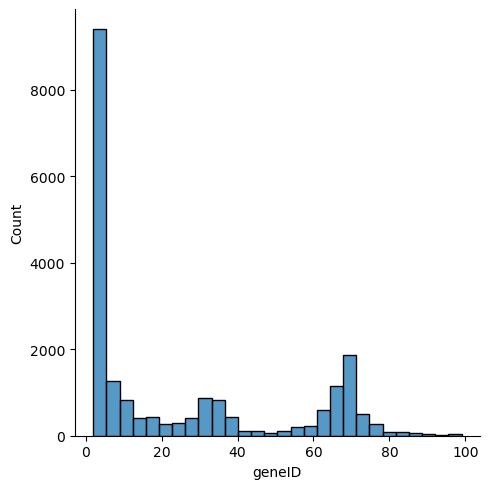

In [50]:
df_filter1 = df_OG_Tritryp_sices[(df_OG_Tritryp_sices['geneID'] > 1) & (df_OG_Tritryp_sices['geneID'] < 100)]


sns.displot(data=df_filter1, 
           x='geneID')


df_filter1.shape

In [51]:
df_OG_Tritryp_sices[(df_OG_Tritryp_sices['geneID'] == 1)].shape

(32215, 2)

In [52]:
df_OG_Tritryp_sices[(df_OG_Tritryp_sices['geneID'] > 1)].shape

(21490, 2)

# Amount of uniprot downloaded - available in AFDB

In [53]:
df_uniprot_pLDDT = pd.read_csv('../../report_files/protein_structure_pLDDT_mean.tsv', sep='\t', header=None, names=['uniprot','pLDDT'])

df_mandatory_uniprot = pd.read_csv('../../mandatory_files/fasta_header_to_uniprot.tsv', sep='\t', header=None, names=['geneID','uniprot'])

In [54]:
df_mandatory_uniprot.merge(df_uniprot_pLDDT).sort_values('pLDDT')

,geneID,uniprot,pLDDT
434673,TcYC6_0106470,A0A2V2WSS0,21
774633,TcIL3000_0_27280,F9W3R0,21
773424,TcIL3000_0_12570,F9WG84,21
711657,Tb11.1670,Q4FK97,21
773423,TcIL3000_0_12560,F9WG83,21
...,...,...,...
148821,ECC02_012776,Q26970,99
148820,C4B63_14g241,Q26970,99
148819,C3747_19g298,Q26970,99
148818,BCY84_10688,Q26970,99


In [55]:
df_mandatory_uniprot.uniprot.nunique()

272483

In [56]:
df_uniprot_pLDDT.uniprot.nunique()

272483

# Protein structure inspection 

In [57]:
df_ortho = pd.read_csv('../../report_files/ortholog_groups_x_sequence_clustering_x_UNIPROT.tsv', sep='\t')

#dataframe with GO annotation informattion
df_gene_information = pd.read_csv('../../tmp/GenesByOrthologPattern_Summary.txt',
                                  sep='\t',
                                  low_memory=False)

ortho_g_count = df_gene_information.groupby('Ortholog Group').size().to_frame()

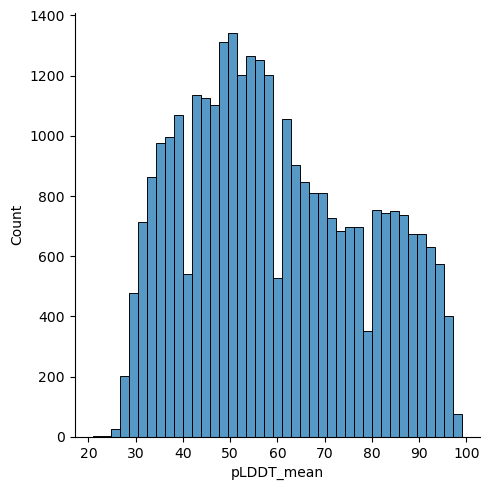

In [58]:
sns.displot(data=df_ortho, x='pLDDT_mean')

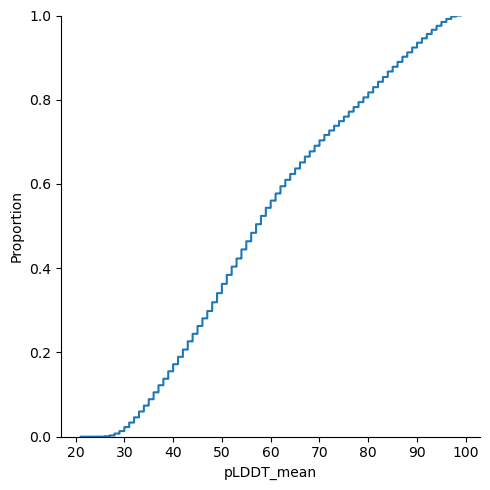

In [59]:
sns.displot(data=df_ortho, x='pLDDT_mean', kind='ecdf')

## Do I have cluster bigger than 1 member without protein structure? 

In [65]:
count_plus_structure = df_ortho.merge(ortho_g_count, left_on='Ortholog_Group', right_index=True)

#son 4245 orthologs groups con mas de 1 miembro sin modelo en AFDB
count_plus_structure_se = count_plus_structure[(count_plus_structure.uniprot.isna()) & (count_plus_structure[0] > 1)]
count_plus_structure_ce = count_plus_structure[~(count_plus_structure.uniprot.isna()) & (count_plus_structure[0] > 1)]


count_plus_structure_1_se = count_plus_structure[(count_plus_structure.uniprot.isna()) & (count_plus_structure[0] == 1)]
count_plus_structure_1_ce = count_plus_structure[~(count_plus_structure.uniprot.isna()) & (count_plus_structure[0] == 1)]

print('OG con mas de un miembro sin estructura asignada:', count_plus_structure_se.shape[0])
print('OG con mas de un miembro con estructura asignada:', count_plus_structure_ce.shape[0])

print('OG con un miembro sin estructura asignada:', count_plus_structure_1_se.shape[0])
print('OG con un miembro con estructura asignada:', count_plus_structure_1_ce.shape[0])

OG con mas de un miembro sin estructura asignada: 4245
OG con mas de un miembro con estructura asignada: 17245
OG con un miembro sin estructura asignada: 18545
OG con un miembro con estructura asignada: 13670


In [97]:
4245 + 17245 + 18545 + 13670

53705

In [279]:
#voy a hacer un fasta file y usar mmseq para clusterizar y modelar menos en principio en scoville

#creating a fasta file of sequences in OrthoG non modelated to cluster by mmseqs2 and modelate
df_to_fasta = df_gene_information[df_gene_information['Ortholog Group'].isin(count_plus_structure.Ortholog_Group.unique())]['Gene ID'].unique()



looking_in_fasta_file(list(df_to_fasta), 
                     '../../tmp/report_files/sequences_to_be_modelated/',
                     'ortho_group_with_more_than_one_member_wo_model_in_AFDB.fasta')

In [93]:
count_plus_structure.Ortholog_Group.nunique()

53705

In [96]:
count_plus_structure.Ortholog_Group.value_counts().sort_values()

OG6_101659    1
OG6_100304    1
OG6_100674    1
OG6_100072    1
OG6_100634    1
             ..
OG6_444176    1
OG6_444236    1
OG6_444442    1
OG6_443850    1
OG6_443833    1
Name: Ortholog_Group, Length: 53705, dtype: int64

# Amount of completely hypothetical clusters

In [81]:
#dataframe with GO annotation informattion
df_gene_information = pd.read_csv('../../tmp/GenesByOrthologPattern_Summary.txt',
                                  sep='\t',
                                  low_memory=False)

df_gene_information['Ortholog Group'].nunique()

53705

In [82]:
print(df_gene_information.shape)

df_gene_information.drop_duplicates(subset=['Gene ID']).shape

(686926, 24)


(686229, 24)

In [83]:
#columns with GO IDs to count NaN instances
nan_columns = df_gene_information[df_gene_information.filter(like = 'ID').columns ].isna() #True if there is no information of GO
nan_columns.columns

Index(['Gene ID', 'Entrez Gene ID', 'UniProt ID(s)',
       'Computed GO Component IDs', 'Computed GO Function IDs',
       'Computed GO Process IDs', 'Curated GO Component IDs',
       'Curated GO Function IDs', 'Curated GO Process IDs'],
      dtype='object')

In [84]:
#counting OG group
df_gene_information_OG_count = df_gene_information.groupby('Ortholog Group').size()

#creating list of them
df_gene_information_OG_count = df_gene_information_OG_count[df_gene_information_OG_count > 1].index

In [85]:
#adding NaN count to original df
df_gene_information  = df_gene_information.merge(nan_columns, left_index=True, right_index=True, suffixes=['_1','_2'])

In [86]:
#removing size-1/non-real ortholog groups
#df_gene_information = df_gene_information[df_gene_information['Ortholog count'] > 1]

df_gene_information = df_gene_information[df_gene_information['Ortholog Group'].isin(df_gene_information_OG_count)]

df_gene_information['Ortholog Group'].nunique()

21490

In [72]:
#selection only GO ID columns
df_gene_information_all_member_noGO = df_gene_information.groupby('Ortholog Group')[[i + '_2' for i in nan_columns.columns]].all()

In [73]:
df_gene_information_all_member_noGO

,Gene ID_2,Entrez Gene ID_2,UniProt ID(s)_2,Computed GO Component IDs_2,Computed GO Function IDs_2,Computed GO Process IDs_2,Curated GO Component IDs_2,Curated GO Function IDs_2,Curated GO Process IDs_2
Ortholog Group,,,,,,,,,
N/A (orthology not determined because protein is too short or has too many stop codons),False,True,True,True,True,True,True,True,True
N/A (orthology not determined for pseudogenes),False,True,True,True,True,True,True,True,True
OG6_100000,False,False,False,False,False,False,False,True,True
OG6_100001,False,False,False,False,True,True,True,True,True
OG6_100006,False,True,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...
OG6r16_535148,False,True,True,True,True,True,True,True,True
OG6r16_535152,False,True,True,True,True,True,True,True,True
OG6r16_535175,False,True,True,True,True,True,True,True,True


## Ortho Groups without GO information. 

In [74]:
print('Total:', df_gene_information_all_member_noGO.shape[0])
df_gene_information_all_member_noGO.sum()

#This is insteresting. We have 1477 OrthoGroups bigger than 1 with no protein structure modelated. We should modelate them. UniProt ID(s)_2 column.

Total: 21490


Gene ID_2                          0
Entrez Gene ID_2                8494
UniProt ID(s)_2                 4190
Computed GO Component IDs_2    14565
Computed GO Function IDs_2     15290
Computed GO Process IDs_2      16775
Curated GO Component IDs_2     13987
Curated GO Function IDs_2      17384
Curated GO Process IDs_2       17438
dtype: int64

# Cluster bigger than 1 with no protein structure available in alphafold 

In [75]:
ortholog_groups_to_modelate = df_gene_information_all_member_noGO[df_gene_information_all_member_noGO['UniProt ID(s)_2'] == True].index#['Ortholog Group'].nunique()

ortholog_groups_to_modelate = df_gene_information[df_gene_information['Ortholog Group'].isin(ortholog_groups_to_modelate)]

In [87]:
ortholog_groups_to_modelate['Ortholog Group'].value_counts()

N/A (orthology not determined because protein is too short or has too many stop codons)    4313
OG6r16_100141                                                                                68
OG6r16_100149                                                                                66
OG6r16_100318                                                                                47
OG6r16_100363                                                                                44
                                                                                           ... 
OG6_443824                                                                                    2
OG6r16_197037                                                                                 2
OG6_553005                                                                                    2
OG6r16_197040                                                                                 2
OG6r16_197819                           

In [88]:
ortholog_groups_to_modelate.shape

(18638, 33)

In [89]:
df_gene_information[df_gene_information['Ortholog Group'] == 'OG6r16_113503']

,Gene ID_1,source_id,Organism,Product Description,Ortholog count,Paralog count,Gene Name or Symbol,Entrez Gene ID_1,UniProt ID(s)_1,Ortholog Group,Computed GO Component IDs_1,Computed GO Components,Computed GO Function IDs_1,Computed GO Functions,Computed GO Process IDs_1,Computed GO Processes,Curated GO Component IDs_1,Curated GO Components,Curated GO Function IDs_1,Curated GO Functions,Curated GO Process IDs_1,Curated GO Processes,EC numbers,EC numbers from OrthoMCL,Gene ID_2,Entrez Gene ID_2,UniProt ID(s)_2,Computed GO Component IDs_2,Computed GO Function IDs_2,Computed GO Process IDs_2,Curated GO Component IDs_2,Curated GO Function IDs_2,Curated GO Process IDs_2
20715,BCY84_17413,BCY84_17413_t1,Trypanosoma cruzi Dm28c 2017,unspecified product,6,0,NaN,NaN,A0A7J6Y4K2,OG6r16_113503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,True,True,True,True,True,True
110539,DQ04_02171030,DQ04_02171030-t26_1,Trypanosoma grayi ANR4,hypothetical protein,5,1,NaN,20381869,NaN,OG6r16_113503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,True,True,True,True,True
110541,DQ04_02171050,DQ04_02171050-t26_1,Trypanosoma grayi ANR4,hypothetical protein,5,1,NaN,20381871,NaN,OG6r16_113503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,True,True,True,True,True
430850,TCDM_02553,TCDM_02553-t26_1,Trypanosoma cruzi Dm28c 2014,hypothetical protein,6,0,NaN,NaN,V5BR53,OG6r16_113503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,True,True,True,True,True,True
464689,TM35_000191690,TM35_000191690-t36_1,Trypanosoma theileri isolate Edinburgh,hypothetical protein,6,0,NaN,39986447,A0A1X0NT97,OG6r16_113503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,True,True,True,True,True
595361,TcG_05631,TcG_05631_t1,Trypanosoma cruzi strain G,hypothetical protein,6,0,NaN,NaN,NaN,OG6r16_113503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,True,True,True,True,True,True,True
663055,Tc_MARK_64,Tc_MARK_64.mRNA,Trypanosoma cruzi marinkellei strain B7,hypothetical protein,6,0,NaN,NaN,NaN,OG6r16_113503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,True,True,True,True,True,True,True


# Clustered non modelated sequences to fasta

In [261]:
clusterTSV = pd.read_csv('../../tmp/report_files/sequences_to_be_modelated/ortho_group_with_more_than_one_member_wo_model_in_AFDB_cluster.tsv', 
            sep='\t',
           header=None)

looking_in_fasta_file(list(clusterTSV[0].unique()), 
                     '../../tmp/report_files/sequences_to_be_modelated_cluster_representar/',
                     'cluster_representer_to_AF.fasta')